### Análise e Predição de atraso de voos dos Estados Unidos (2009-2018)

#### Objetivo: Predizer se um voo tem chance de ser cancelado ou não
##### ML: Regressão Linear, XGboost e Floresta Aleatória

- Cada linha do conjunto de dados representa voos específicos daquele ano. As colunas contêm informações sobre o voo, companhia aérea, data do voo, atraso de partida, atraso de chegada, e outros.
- Se cancelado (1), todos os horarios de decolagem e chegada serão 'null'
- Filtrar Voos Cancelados para uma analise exploratoria
- DEP_DELAY: Se negativo, decolou antecipadamente
- ARR_DELAY: Se negativo, chegou antecipadamente
- *Se os dois forem negativos, não houve atrasos*
- *Somar ARR_DELAY + DEP_DELAY = Se negativo ou 0, é 'Not delayed'. Se positivo, 'Delayed'.*
- *Criar nova coluna pra definir se houve atraso ou não (DELAY_FINAL)*

#### Cenarios possiveis
- Check posteriormente relação entre distancia e atraso: se a media de distancia entre aeroporto A para aeroporto B é X, pouca chance de atrasar. Se distancia é 30% maior que a media, a chance de atrasar é maior;
- Se alta demanda de voos em determinado periodo é muito maior que a média, a chance de atrasar é maior;
- Rodar modelo com mais variaveis ("OP_CARRIER_FL_NUM" , "DISTANCE", "ORIGIN", "DEST") //// Numero voo, distancia total percorrida, origem do voo, destino do voo;
- Calcular média de atraso em minutos ou horas por mês e operadora (O que é um grande atraso? Definir corte (até 30 min, até 60 min)

<br>

### Carregando Spark e dados

In [ ]:
# Criar a sessao do Spark
from pyspark.sql import SparkSession
spark = SparkSession \
            .builder \
            .master("local[*]") \
            .appName("SparkML") \
            .getOrCreate()

In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt


import pyspark.sql.functions as f
from pyspark.sql.types import StringType
from pyspark.ml.feature import VectorAssembler, StandardScaler #suporte para dados esparsos
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.regression import LinearRegression #rodar o modelo de regressão linear
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
import warnings
warnings.filterwarnings('ignore')


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType

spark = SparkSession.builder.getOrCreate()

schema = StructType([
    StructField("FL_DATE", TimestampType(), nullable=True),
    StructField("OP_CARRIER", StringType(), nullable=True),
    StructField("OP_CARRIER_FL_NUM", StringType(), nullable=True),
    StructField("ORIGIN", StringType(), nullable=True),
    StructField("DEST", StringType(), nullable=True),
    StructField("CRS_DEP_TIME", DoubleType(), nullable=True),
    StructField("DEP_TIME", DoubleType(), nullable=True),
    StructField("DEP_DELAY", DoubleType(), nullable=True),
    StructField("TAXI_OUT", DoubleType(), nullable=True),
    StructField("WHEELS_OFF", DoubleType(), nullable=True),
    StructField("WHEELS_ON", DoubleType(), nullable=True),
    StructField("TAXI_IN", DoubleType(), nullable=True),
    StructField("CRS_ARR_TIME", DoubleType(), nullable=True),
    StructField("ARR_TIME", DoubleType(), nullable=True),
    StructField("ARR_DELAY", DoubleType(), nullable=True),
    StructField("CANCELLED", DoubleType(), nullable=True),
    StructField("CANCELLATION_CODE", StringType(), nullable=True),
    StructField("DIVERTED", DoubleType(), nullable=True),
    StructField("CRS_ELAPSED_TIME", DoubleType(), nullable=True),
    StructField("ACTUAL_ELAPSED_TIME", DoubleType(), nullable=True),
    StructField("AIR_TIME", DoubleType(), nullable=True),
    StructField("DISTANCE", DoubleType(), nullable=True),
    StructField("CARRIER_DELAY", DoubleType(), nullable=True),
    StructField("WEATHER_DELAY", DoubleType(), nullable=True),
    StructField("NAS_DELAY", DoubleType(), nullable=True),
    StructField("SECURITY_DELAY", DoubleType(), nullable=True),
    StructField("LATE_AIRCRAFT_DELAY", DoubleType(), nullable=True),
    StructField("Unnamed: 27", StringType(), nullable=True)
])


In [ ]:
df = spark.read.csv('2009.csv',
                      header=True,
                      inferSchema=False, schema=schema)

In [ ]:
# Print the schema
df.printSchema()

root
 |-- FL_DATE: timestamp (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: double (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: double (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = true)
 |-- WEATHER_DELAY: do

In [ ]:
df.schema

StructType([StructField('FL_DATE', TimestampType(), True), StructField('OP_CARRIER', StringType(), True), StructField('OP_CARRIER_FL_NUM', StringType(), True), StructField('ORIGIN', StringType(), True), StructField('DEST', StringType(), True), StructField('CRS_DEP_TIME', DoubleType(), True), StructField('DEP_TIME', DoubleType(), True), StructField('DEP_DELAY', DoubleType(), True), StructField('TAXI_OUT', DoubleType(), True), StructField('WHEELS_OFF', DoubleType(), True), StructField('WHEELS_ON', DoubleType(), True), StructField('TAXI_IN', DoubleType(), True), StructField('CRS_ARR_TIME', DoubleType(), True), StructField('ARR_TIME', DoubleType(), True), StructField('ARR_DELAY', DoubleType(), True), StructField('CANCELLED', DoubleType(), True), StructField('CANCELLATION_CODE', StringType(), True), StructField('DIVERTED', DoubleType(), True), StructField('CRS_ELAPSED_TIME', DoubleType(), True), StructField('ACTUAL_ELAPSED_TIME', DoubleType(), True), StructField('AIR_TIME', DoubleType(), Tr

<br>

## Missing values

In [ ]:
from pyspark.sql.functions import col, sum

# Calcula o total de linhas no DataFrame
total_rows = df.count()
total_rows

6429338

In [ ]:
# Conta os missings em cada coluna do df
total_missing_values = df.select([sum(col(column).isNull().cast("integer")).alias(column) for column in df.columns])

# Cria um df que conta o total de missings e add uma nova coluna
missing_table = spark.createDataFrame([(column, value) for column, value in zip(df.columns, total_missing_values.first())], ["Column", "Missing Values"])

# Calculate o percentual de missing
missing_table = missing_table.withColumn("Percentage", (col("Missing Values") / total_rows) * 100)

# Ordena do maior para o menor percentual
missing_table = missing_table.orderBy(col("Percentage").desc())

missing_table.show()


+-------------------+--------------+------------------+
|             Column|Missing Values|        Percentage|
+-------------------+--------------+------------------+
|        Unnamed: 27|       6429338|             100.0|
|  CANCELLATION_CODE|       6342300| 98.64623698427427|
|     SECURITY_DELAY|       5258837|  81.7943775859972|
|LATE_AIRCRAFT_DELAY|       5258837|  81.7943775859972|
|      CARRIER_DELAY|       5258837|  81.7943775859972|
|      WEATHER_DELAY|       5258837|  81.7943775859972|
|          NAS_DELAY|       5258837|  81.7943775859972|
|ACTUAL_ELAPSED_TIME|        102362|1.5921079277524373|
|          ARR_DELAY|        102361|1.5920923740515742|
|           AIR_TIME|        102361|1.5920923740515742|
|          WHEELS_ON|         89322|1.3892876684971298|
|           ARR_TIME|         89322|1.3892876684971298|
|            TAXI_IN|         89321|1.3892721147962668|
|         WHEELS_OFF|         85787|1.3343053359459405|
|           TAXI_OUT|         85787|1.3343053359

In [ ]:
from pyspark.sql.functions import col, count

# entendendo o total de missings de CANCELLATION_CODE do arquivo 2009

missing_cancel_code = df.groupBy("CANCELLATION_CODE").agg(count("*").alias("Missing_qty"))
total_missing_code = df.count()
missing_cancel_code = missing_cancel_code.withColumn("%", (col("Missing_qty") / total_missing_code) * 100)
missing_cancel_code = missing_cancel_code.sort(col("%").desc())
missing_cancel_code.show()

+-----------------+-----------+--------------------+
|CANCELLATION_CODE|Missing_qty|                   %|
+-----------------+-----------+--------------------+
|             null|    6342300|   98.64623698427427|
|                B|      36651|   0.570058690334837|
|                A|      35568|  0.5532140323000595|
|                C|      14799|  0.2301792190735656|
|                D|         20|3.110740172627415E-4|
+-----------------+-----------+--------------------+



In [ ]:
# Drop nas linhas com null em ARR_DELAY and DEP_DELAY
df = df.dropna(subset=["ARR_DELAY", "DEP_DELAY"])

> Total de linhas no df depois de excluir linhas com NA

In [ ]:
rows_after_drop = df.count()
rows_after_drop

6326977

<br>

## Tratamento

In [ ]:
# criado uma nova coluna indicando o mês do ano do voo

from pyspark.sql.functions import col, month
df = df.withColumn('FL_DATE', col('FL_DATE').cast('date'))
df = df.withColumn('FL_DATE_month', month(col('FL_DATE')))



In [ ]:
# check dia 01-01-2009

# dia_01 = df.filter(col('FL_DATE') == '2009-01-01').limit(10)
# dia_01.limit(5).toPandas()

In [ ]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType

# Definindo os nomes das companhias
airline_name = {
    'UA': 'United Airlines',
    'AS': 'Alaska Airlines',
    '9E': 'Endeavor Air',
    'B6': 'JetBlue Airways',
    'EV': 'ExpressJet',
    'F9': 'Frontier Airlines',
    'G4': 'Allegiant Air',
    'HA': 'Hawaiian Airlines',
    'MQ': 'Envoy Air',
    'NK': 'Spirit Airlines',
    'OH': 'PSA Airlines',
    'OO': 'SkyWest Airlines',
    'VX': 'Virgin America',
    'WN': 'Southwest Airlines',
    'YV': 'Mesa Airline',
    'YX': 'Republic Airways',
    'AA': 'American Airlines',
    'DL': 'Delta Airlines',
    'XE': 'JetsuiteX',
    'US': 'US Airlines',
    'NW': 'Northwest Airlines',
    'CO': 'Continental Airlines',
    'FL': 'AirTran Airways',
}

# (UDF) to map airline codes to company names
get_airline_name = udf(lambda code: airline_name.get(code), StringType())

# Nova coluna 'AIRLINE_NAME' com o nome das companhias aereas
df = df.withColumn('AIRLINE_NAME', get_airline_name(col('OP_CARRIER')))

In [ ]:
df.limit(5).toPandas()

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 27,FL_DATE_month,AIRLINE_NAME
0,2009-01-01,XE,1204,DCA,EWR,1100.0,1058.0,-2.0,18.0,1116.0,...,42.0,199.0,NaN,NaN,NaN,NaN,NaN,None,1,JetsuiteX
1,2009-01-01,XE,1206,EWR,IAD,1510.0,1509.0,-1.0,28.0,1537.0,...,43.0,213.0,NaN,NaN,NaN,NaN,NaN,None,1,JetsuiteX
2,2009-01-01,XE,1207,EWR,DCA,1100.0,1059.0,-1.0,20.0,1119.0,...,36.0,199.0,NaN,NaN,NaN,NaN,NaN,None,1,JetsuiteX
3,2009-01-01,XE,1208,DCA,EWR,1240.0,1249.0,9.0,10.0,1259.0,...,37.0,199.0,NaN,NaN,NaN,NaN,NaN,None,1,JetsuiteX
4,2009-01-01,XE,1209,IAD,EWR,1715.0,1705.0,-10.0,24.0,1729.0,...,40.0,213.0,NaN,NaN,NaN,NaN,NaN,None,1,JetsuiteX


<br>

> Check the missing after the cleaning

In [ ]:
from pyspark.sql.functions import col, sum

total_missing_values = df.select([sum(col(column).isNull().cast("integer")).alias(column) for column in df.columns])
missing_table = spark.createDataFrame([(column, value) for column, value in zip(df.columns, total_missing_values.first())], ["Column", "Missing Values"])
missing_table = missing_table.withColumn("Percentage", (col("Missing Values") / total_rows) * 100)
missing_table = missing_table.orderBy(col("Percentage").desc())
missing_table.show()

+-------------------+--------------+--------------------+
|             Column|Missing Values|          Percentage|
+-------------------+--------------+--------------------+
|  CANCELLATION_CODE|       6326977|   98.40790762594843|
|        Unnamed: 27|       6326977|   98.40790762594843|
|      WEATHER_DELAY|       5156476|   80.20228521194561|
|          NAS_DELAY|       5156476|   80.20228521194561|
|      CARRIER_DELAY|       5156476|   80.20228521194561|
|     SECURITY_DELAY|       5156476|   80.20228521194561|
|LATE_AIRCRAFT_DELAY|       5156476|   80.20228521194561|
|           ARR_TIME|             1|1.555370086313707...|
|ACTUAL_ELAPSED_TIME|             1|1.555370086313707...|
|          WHEELS_ON|             1|1.555370086313707...|
|           AIR_TIME|             0|                 0.0|
|  OP_CARRIER_FL_NUM|             0|                 0.0|
|             ORIGIN|             0|                 0.0|
|          DEP_DELAY|             0|                 0.0|
|         WHEE

## Analisando os dados

> Total flights in 2009

In [ ]:
total_voos = df.count()
print('Temos um total de',total_voos,'voos')

Temos um total de 6326977 voos


> Total distinct Airlines in 2009

In [ ]:
airlines_count = df.select("OP_CARRIER").distinct().count()
print("Number of distinct airlines:", airlines_count)


Number of distinct airlines: 19


<br>

> Total flights by ORIGIN / Airports

In [ ]:
from pyspark.sql.functions import count, col

# total de voos por aeroporto
total_flights = df.groupBy("ORIGIN").agg(count("*").alias("flight_count"))
# classifica do maior para o menor
sorted_airports = total_flights.orderBy(col("flight_count").desc())

sorted_airports.show()

+------+------------+
|ORIGIN|flight_count|
+------+------------+
|   ATL|      411010|
|   ORD|      306396|
|   DFW|      258840|
|   DEN|      232677|
|   LAX|      190665|
|   PHX|      181887|
|   IAH|      180451|
|   LAS|      152777|
|   DTW|      150185|
|   SFO|      134650|
|   SLC|      130560|
|   MCO|      119939|
|   MSP|      118227|
|   JFK|      116687|
|   EWR|      115343|
|   CLT|      115273|
|   BOS|      107350|
|   SEA|      100231|
|   BWI|       99683|
|   LGA|       96069|
+------+------------+
only showing top 20 rows



> Which Airline have the highest Average distance travelled by Distance?

In [ ]:
from pyspark.sql.functions import avg, desc, count

# Calcula a média de distância percorrida por cada 'ORIGIN' e 'OP_CARRIER'
avg_distance = df.groupBy("AIRLINE_NAME", "OP_CARRIER").agg(avg("DISTANCE").alias("avg_distance"))

# Calcula o total de voos para cada Airline
total_flights = df.groupBy("AIRLINE_NAME").agg(count("*").alias("total_flights"))

# Join entre os dataframes criados: 'avg_distance' e 'total_flights', agrupando por Airline
table_distance_flights = avg_distance.join(total_flights, "AIRLINE_NAME", "inner")

# Classifica pela maior distância média
table_distance_flights = table_distance_flights.orderBy(desc("total_flights"))

table_distance_flights.show()

+--------------------+----------+------------------+-------------+
|        AIRLINE_NAME|OP_CARRIER|      avg_distance|total_flights|
+--------------------+----------+------------------+-------------+
|  Southwest Airlines|        WN| 639.2343220338983|      1118640|
|   American Airlines|        AA| 1051.582317723649|       539003|
|    SkyWest Airlines|        OO|445.69235421085926|       537420|
|           Envoy Air|        MQ|418.52932891700993|       423882|
|      Delta Airlines|        DL| 928.3996401567888|       420183|
|         US Airlines|        US| 858.0384637160996|       406227|
|     United Airlines|        UA|1110.6336165810967|       369288|
|           JetsuiteX|        XE| 566.5555588542852|       303147|
|          ExpressJet|        EV| 405.0098435999451|       291560|
|  Northwest Airlines|        NW| 876.9985246314164|       290097|
|        Endeavor Air|        9E| 411.7583852648214|       256909|
|Continental Airlines|        CO|1191.2459035727763|       254

> Top 10 Airports with more flights in 2009

In [ ]:
# 10 principais aeroportos
top_10_airports = df.groupBy("ORIGIN").agg(count("*").alias("flight_count")) \
    .orderBy(col("flight_count").desc()).limit(10)

top_10_airports.show()

+------+------------+
|ORIGIN|flight_count|
+------+------------+
|   ATL|      411010|
|   ORD|      306396|
|   DFW|      258840|
|   DEN|      232677|
|   LAX|      190665|
|   PHX|      181887|
|   IAH|      180451|
|   LAS|      152777|
|   DTW|      150185|
|   SFO|      134650|
+------+------------+



<br>

## Rodar o drop de colunas após analise 2018 e 2014

In [ ]:
df = df.drop(
    'Unnamed: 27', # high percent of null
    'CANCELLATION_CODE',
    'LATE_AIRCRAFT_DELAY',
    'SECURITY_DELAY',
    'NAS_DELAY', # high percent of null
    'WEATHER_DELAY', # option
    'CARRIER_DELAY',
    "CRS_DEP_TIME",
    "DEP_TIME",
    "TAXI_OUT",
    "WHEELS_OFF",
    "WHEELS_ON",
    "TAXI_IN",
    "CRS_ARR_TIME",
    "ARR_TIME",
    "DIVERTED",
    "CRS_ELAPSED_TIME",
    "ACTUAL_ELAPSED_TIME",
    "AIR_TIME", # option
    )

In [ ]:
df.limit(10).toPandas()

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,DEP_DELAY,ARR_DELAY,CANCELLED,DISTANCE,FL_DATE_month,AIRLINE_NAME
0,2009-01-01,XE,1204,DCA,EWR,-2.0,4.0,0.0,199.0,1,JetsuiteX
1,2009-01-01,XE,1206,EWR,IAD,-1.0,-8.0,0.0,213.0,1,JetsuiteX
2,2009-01-01,XE,1207,EWR,DCA,-1.0,-9.0,0.0,199.0,1,JetsuiteX
3,2009-01-01,XE,1208,DCA,EWR,9.0,-12.0,0.0,199.0,1,JetsuiteX
4,2009-01-01,XE,1209,IAD,EWR,-10.0,-38.0,0.0,213.0,1,JetsuiteX
5,2009-01-01,XE,1212,ATL,EWR,-2.0,-19.0,0.0,745.0,1,JetsuiteX
6,2009-01-01,XE,1212,CLE,ATL,-8.0,-17.0,0.0,554.0,1,JetsuiteX
7,2009-01-01,XE,1214,DCA,EWR,-7.0,-8.0,0.0,199.0,1,JetsuiteX
8,2009-01-01,XE,1215,EWR,DCA,-5.0,-15.0,0.0,199.0,1,JetsuiteX
9,2009-01-01,XE,1217,EWR,DCA,-5.0,-12.0,0.0,199.0,1,JetsuiteX


In [ ]:
from pyspark.sql.functions import col, sum

total_missing_values = df.select([sum(col(column).isNull().cast("integer")).alias(column) for column in df.columns])
missing_table = spark.createDataFrame([(column, value) for column, value in zip(df.columns, total_missing_values.first())], ["Column", "Missing Values"])
missing_table = missing_table.withColumn("Percentage", (col("Missing Values") / total_rows) * 100)
missing_table = missing_table.orderBy(col("Percentage").desc())
missing_table.show()

+-----------------+--------------+----------+
|           Column|Missing Values|Percentage|
+-----------------+--------------+----------+
|        DEP_DELAY|             0|       0.0|
|        ARR_DELAY|             0|       0.0|
|        CANCELLED|             0|       0.0|
|         DISTANCE|             0|       0.0|
|    FL_DATE_month|             0|       0.0|
|     AIRLINE_NAME|             0|       0.0|
|          FL_DATE|             0|       0.0|
|       OP_CARRIER|             0|       0.0|
|OP_CARRIER_FL_NUM|             0|       0.0|
|           ORIGIN|             0|       0.0|
|             DEST|             0|       0.0|
+-----------------+--------------+----------+



In [ ]:
df.groupBy('AIRLINE_NAME').count().show()

+--------------------+-------+
|        AIRLINE_NAME|  count|
+--------------------+-------+
|         US Airlines| 406227|
|        Mesa Airline| 237814|
|  Northwest Airlines| 290097|
|     United Airlines| 369288|
|   Hawaiian Airlines|  72538|
|Continental Airlines| 254368|
|          ExpressJet| 291560|
|    SkyWest Airlines| 537420|
|   Frontier Airlines|  86425|
|        Endeavor Air| 256909|
|   American Airlines| 539003|
|     AirTran Airways| 247430|
|     JetBlue Airways| 191043|
|           Envoy Air| 423882|
|      Delta Airlines| 420183|
|        PSA Airlines| 145470|
|     Alaska Airlines| 135533|
|           JetsuiteX| 303147|
|  Southwest Airlines|1118640|
+--------------------+-------+



<br>

## Criando nossa variável explicada

In [ ]:
# Criando script com nossa var

from pyspark.sql.functions import col, when

# Soma DEP_DELAY + ARR_DELAY
df = df.withColumn('DELAY_CALCULATE', col('DEP_DELAY') + col('ARR_DELAY'))


In [ ]:
# Cria a coluna que indica se atrasou ou não, com base em nosso objetivo voltado a experi do cliente 'DELAY_FINAL'
df = df.withColumn('DELAY_RESULT', when(col('DELAY_CALCULATE') <= 0, 'NOT DELAYED').otherwise('DELAYED'))

In [ ]:
# Nova coluna com valor booleano para rodar modelo estatistico

df = df.withColumn('DELAY_BOOLEAN', when(col('DELAY_RESULT') == 'DELAYED', 1) .otherwise(0))

In [ ]:
df.limit(10).toPandas()

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,DEP_DELAY,ARR_DELAY,CANCELLED,DISTANCE,FL_DATE_month,AIRLINE_NAME,DELAY_CALCULATE,DELAY_RESULT,DELAY_BOOLEAN
0,2009-01-01,XE,1204,DCA,EWR,-2.0,4.0,0.0,199.0,1,JetsuiteX,2.0,DELAYED,1
1,2009-01-01,XE,1206,EWR,IAD,-1.0,-8.0,0.0,213.0,1,JetsuiteX,-9.0,NOT DELAYED,0
2,2009-01-01,XE,1207,EWR,DCA,-1.0,-9.0,0.0,199.0,1,JetsuiteX,-10.0,NOT DELAYED,0
3,2009-01-01,XE,1208,DCA,EWR,9.0,-12.0,0.0,199.0,1,JetsuiteX,-3.0,NOT DELAYED,0
4,2009-01-01,XE,1209,IAD,EWR,-10.0,-38.0,0.0,213.0,1,JetsuiteX,-48.0,NOT DELAYED,0
5,2009-01-01,XE,1212,ATL,EWR,-2.0,-19.0,0.0,745.0,1,JetsuiteX,-21.0,NOT DELAYED,0
6,2009-01-01,XE,1212,CLE,ATL,-8.0,-17.0,0.0,554.0,1,JetsuiteX,-25.0,NOT DELAYED,0
7,2009-01-01,XE,1214,DCA,EWR,-7.0,-8.0,0.0,199.0,1,JetsuiteX,-15.0,NOT DELAYED,0
8,2009-01-01,XE,1215,EWR,DCA,-5.0,-15.0,0.0,199.0,1,JetsuiteX,-20.0,NOT DELAYED,0
9,2009-01-01,XE,1217,EWR,DCA,-5.0,-12.0,0.0,199.0,1,JetsuiteX,-17.0,NOT DELAYED,0


In [ ]:
df.groupBy('DELAY_RESULT').count().show()

+------------+-------+
|DELAY_RESULT|  count|
+------------+-------+
| NOT DELAYED|3926390|
|     DELAYED|2400587|
+------------+-------+



In [ ]:
from pyspark.sql.functions import col

# Convertendo "DELAY_CALCULATE" para Integer type // double type poderia estar interferindo no modelo de regressão linear
df = df.withColumn("DELAY_CALCULATE", col("DELAY_CALCULATE").cast("integer"))

In [ ]:
# Print the schema
df.printSchema()

root
 |-- FL_DATE: date (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- FL_DATE_month: integer (nullable = true)
 |-- AIRLINE_NAME: string (nullable = true)
 |-- DELAY_CALCULATE: integer (nullable = true)
 |-- DELAY_RESULT: string (nullable = false)
 |-- DELAY_BOOLEAN: integer (nullable = false)



## Data Visualization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

### Total flights by Month - breakdown by DELAY_RESULT

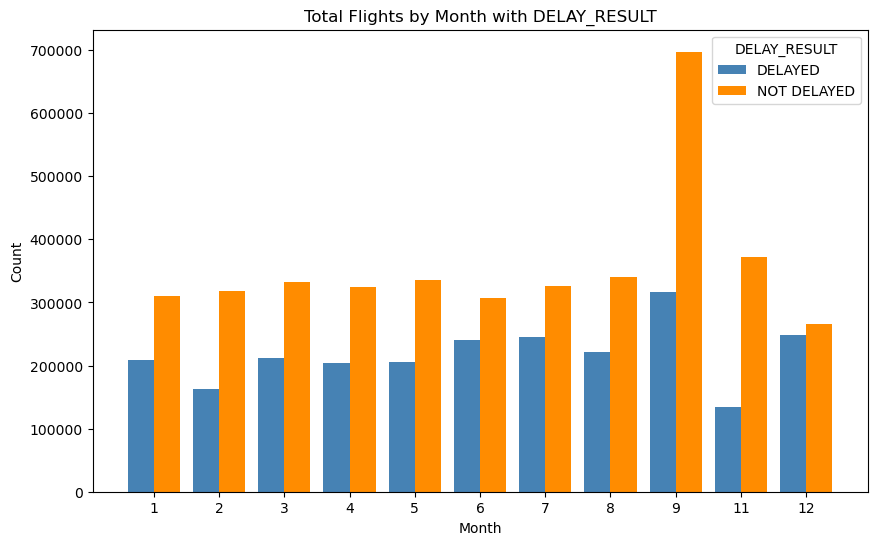

In [ ]:
# Group by FL_DATE_month and DELAY_FINAL, and count the number of flights
count_by_month_delay = df.groupBy('FL_DATE_month', 'DELAY_RESULT').count().orderBy('FL_DATE_month')

# Convert the result to a Pandas DataFrame for plotting
count_by_month_delay_pd = count_by_month_delay.toPandas()

# Pivot the DataFrame to reshape it for plotting
pivot_table = count_by_month_delay_pd.pivot(index='FL_DATE_month', columns='DELAY_RESULT', values='count')

# Get the months and DELAY_FINAL categories
months = pivot_table.index
delay_final_categories = pivot_table.columns

# Set the width and offset for each bar
total_bars = len(delay_final_categories)
bar_width = 0.8 / total_bars
bar_offset = np.arange(len(months)) - (total_bars - 1) * bar_width / 2

# Create a color palette for the bars
colors = ['steelblue', 'darkorange']

# Plot the bars side by side
plt.figure(figsize=(10, 6))
for i, category in enumerate(delay_final_categories):
    plt.bar(bar_offset + i * bar_width, pivot_table[category], width=bar_width, label=category, color=colors[i])

# Customize the plot
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Total Flights by Month with DELAY_RESULT')
plt.xticks(range(len(months)), months)
plt.legend(title='DELAY_RESULT')
plt.show()



<br>

### Total flights by Month and DELAY_RESULT

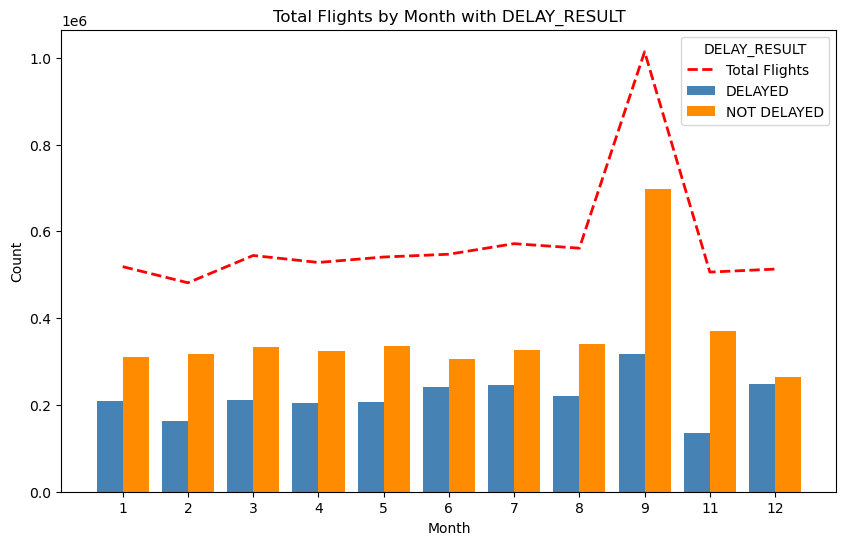

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Group by FL_DATE_month and DELAY_FINAL, and count the number of flights
count_by_month_delay = df.groupBy('FL_DATE_month', 'DELAY_RESULT').count().orderBy('FL_DATE_month')

# Convert the result to a Pandas DataFrame for plotting
count_by_month_delay_pd = count_by_month_delay.toPandas()

# Pivot the DataFrame to reshape it for plotting
pivot_table = count_by_month_delay_pd.pivot(index='FL_DATE_month', columns='DELAY_RESULT', values='count')

# Get the months and DELAY_FINAL categories
months = pivot_table.index
delay_final_categories = pivot_table.columns

# Set the width and offset for each bar
total_bars = len(delay_final_categories)
bar_width = 0.8 / total_bars
bar_offset = np.arange(len(months)) - (total_bars - 1) * bar_width / 2

# Create a color palette for the bars
colors = ['steelblue', 'darkorange']

# Plot the bars side by side
plt.figure(figsize=(10, 6))
for i, category in enumerate(delay_final_categories):
    plt.bar(bar_offset + i * bar_width, pivot_table[category], width=bar_width, label=category, color=colors[i])

# Calculate the total flights per month
total_flights = pivot_table.sum(axis=1)

# Plot a line for the total flights
plt.plot(range(len(months)), total_flights, color='red', linestyle='--', linewidth=2, label='Total Flights')

# Customize the plot
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Total Flights by Month with DELAY_RESULT')
plt.xticks(range(len(months)), months)
plt.legend(title='DELAY_RESULT')
plt.show()


### Total flights by Airline

In [ ]:
df.groupBy('AIRLINE_NAME').count().show()

# total de voos por companhia aerea
total_carriers = df.groupBy("AIRLINE_NAME").agg(count("*").alias("flight_count"))
# Total distance per airline
total_distance = df.groupBy("AIRLINE_NAME").agg(sum("DISTANCE").alias("total_distance"))
# Join the two aggregations on the "AIRLINE_NAME" column
total_carriers = total_carriers.join(total_distance, "AIRLINE_NAME")
# classifica do maior para o menor
total_carriers = total_carriers.orderBy(col("flight_count").desc())

total_carriers.show()

+--------------------+-------+
|        AIRLINE_NAME|  count|
+--------------------+-------+
|         US Airlines| 406227|
|        Mesa Airline| 237814|
|  Northwest Airlines| 290097|
|     United Airlines| 369288|
|   Hawaiian Airlines|  72538|
|Continental Airlines| 254368|
|          ExpressJet| 291560|
|    SkyWest Airlines| 537420|
|   Frontier Airlines|  86425|
|        Endeavor Air| 256909|
|   American Airlines| 539003|
|     AirTran Airways| 247430|
|     JetBlue Airways| 191043|
|           Envoy Air| 423882|
|      Delta Airlines| 420183|
|        PSA Airlines| 145470|
|     Alaska Airlines| 135533|
|           JetsuiteX| 303147|
|  Southwest Airlines|1118640|
+--------------------+-------+

+--------------------+------------+--------------+
|        AIRLINE_NAME|flight_count|total_distance|
+--------------------+------------+--------------+
|  Southwest Airlines|     1118640|  7.15073082E8|
|   American Airlines|      539003|  5.66806024E8|
|    SkyWest Airlines|      537

### Delays by airlines

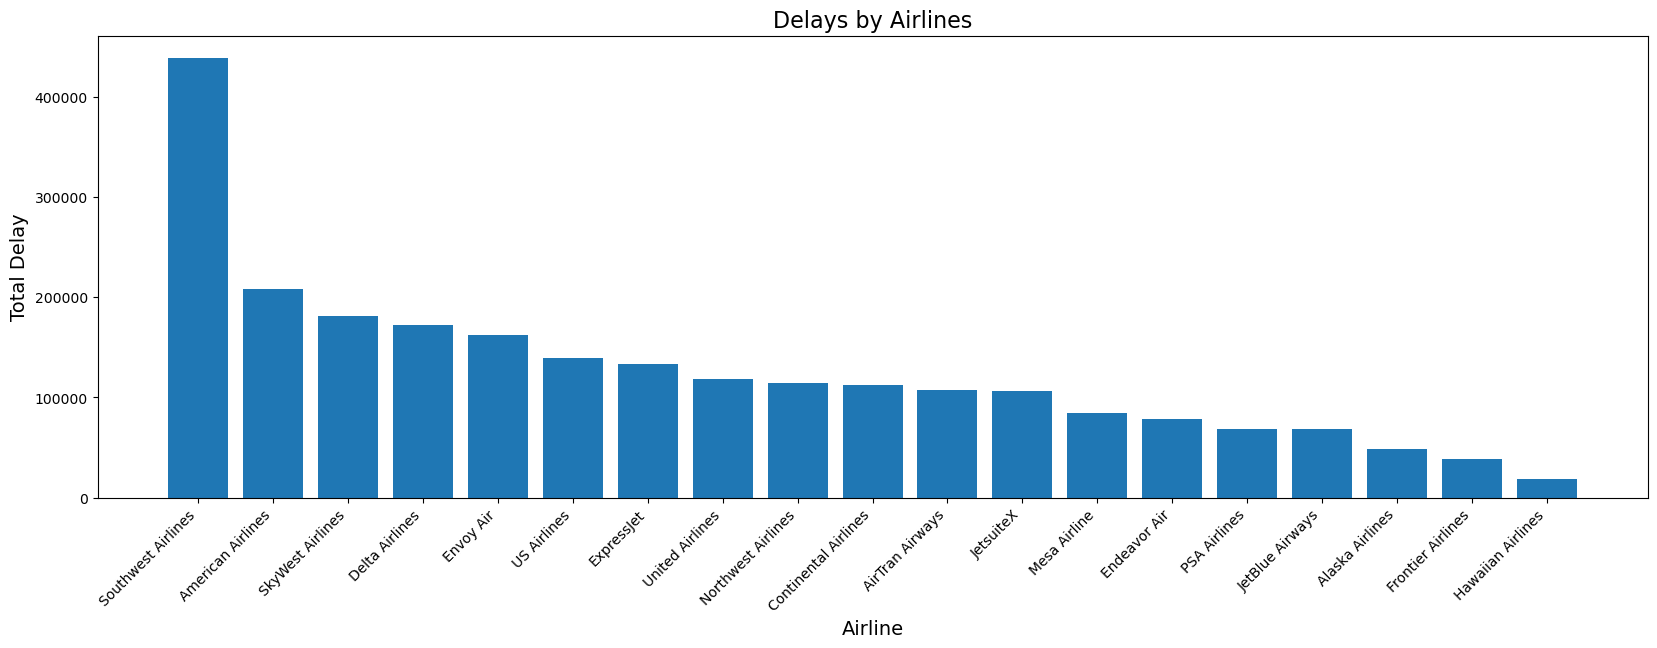

In [ ]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

# Group by AIRLINE_NAME and calculate the sum of ARR_DELAY
delays_by_airline = df.filter(df.AIRLINE_NAME.isNotNull()).groupBy('AIRLINE_NAME').agg(F.sum('DELAY_BOOLEAN').alias('total_delays'))

# Convert the grouped DataFrame to Pandas for plotting
delays_by_airline_pd = delays_by_airline.toPandas()

# Sort the DataFrame by Total_ARR_DELAY in descending order
delays_by_airline_pd = delays_by_airline_pd.sort_values('total_delays', ascending=False)

# Plotting
plt.figure(figsize=(20, 6))
plt.bar(delays_by_airline_pd['AIRLINE_NAME'], delays_by_airline_pd['total_delays'])
plt.title('Delays by Airlines', fontsize=16)
plt.xlabel('Airline', fontsize=14)
plt.ylabel('Total Delay', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.show()


###  Arrival and departure delays by month of the year. Where are they: departure or arrivals?

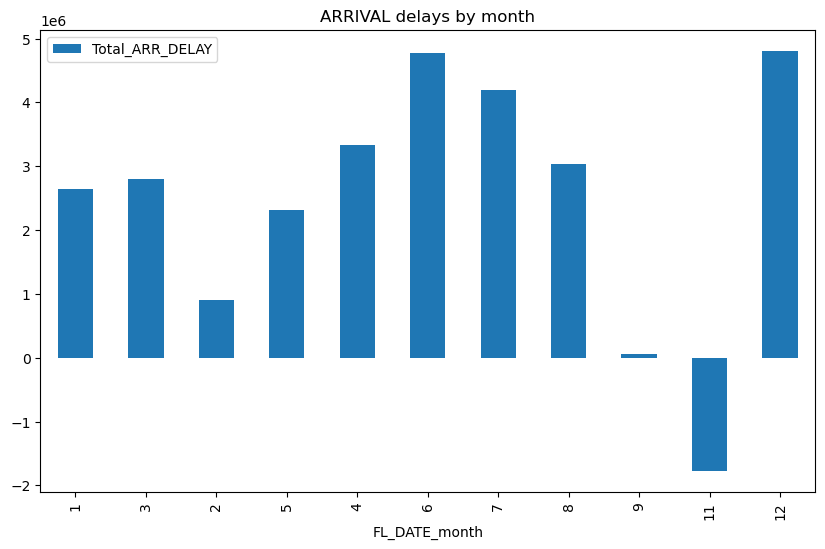

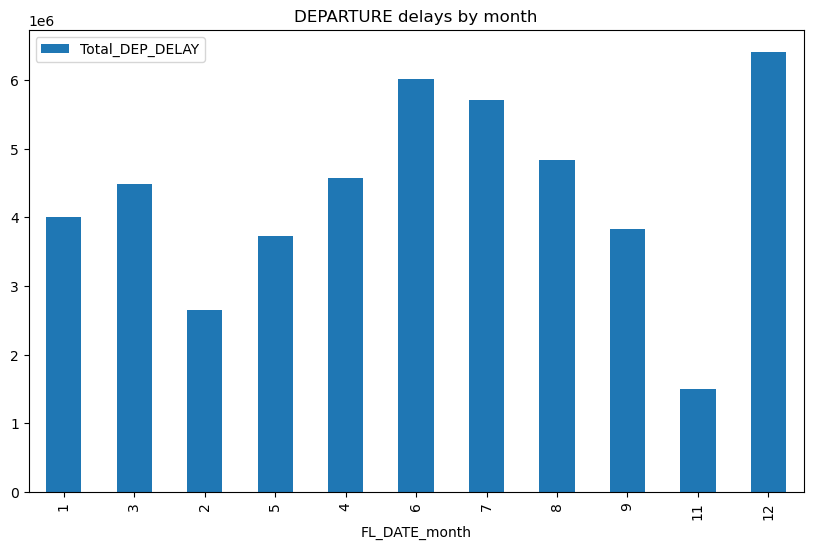

In [ ]:
from pyspark.sql.functions import month
import pyspark.sql.functions as F

# Group by FL_DATE_month and calculate the sum of ARR_DELAY and DEP_DELAY
arrival_delays = df.groupBy(month("FL_DATE").alias("FL_DATE_month")).agg(F.sum("ARR_DELAY").alias("Total_ARR_DELAY"))
departure_delays = df.groupBy(month("FL_DATE").alias("FL_DATE_month")).agg(F.sum("DEP_DELAY").alias("Total_DEP_DELAY"))

# Convert the grouped DataFrames to Pandas for plotting
arrival_delays_pd = arrival_delays.toPandas()
departure_delays_pd = departure_delays.toPandas()

# Plotting
arrival_delays_pd.plot.bar(x='FL_DATE_month', y='Total_ARR_DELAY', title='ARRIVAL delays by month', figsize=(10, 6))
departure_delays_pd.plot.bar(x='FL_DATE_month', y='Total_DEP_DELAY', title='DEPARTURE delays by month', figsize=(10, 6))

plt.show()



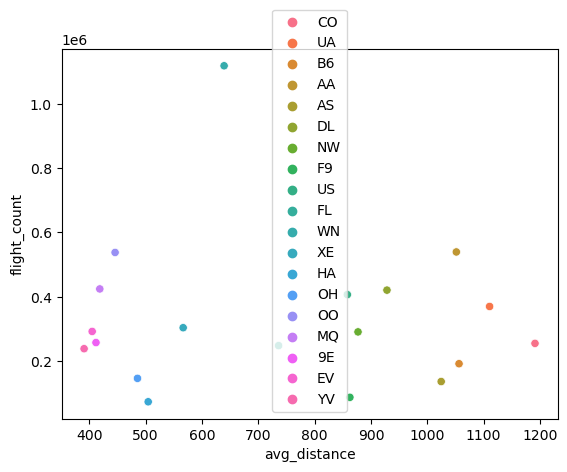

In [ ]:
import matplotlib.pyplot as plt

# Calculate the average distance and count of flights by airline name
avg_distance_df = df.groupBy("OP_CARRIER").agg(avg("DISTANCE").alias("avg_distance"), count("*").alias("flight_count"))
avg_distance_df = avg_distance_df.orderBy("avg_distance", ascending=False)

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = avg_distance_df.toPandas()

# Plot scatter plot using seaborn
sns.scatterplot(data=pandas_df, x="avg_distance", y="flight_count", hue="OP_CARRIER")

# Show the legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
%whos

Variable                  Type                 Data/Info
--------------------------------------------------------
CrossValidator            ABCMeta              <class 'pyspark.ml.tuning.CrossValidator'>
DoubleType                DataTypeSingleton    <class 'pyspark.sql.types.DoubleType'>
F                         module               <module 'pyspark.sql.func<...>yspark/sql/functions.py'>
IntegerType               DataTypeSingleton    <class 'pyspark.sql.types.IntegerType'>
LinearRegression          ABCMeta              <class 'pyspark.ml.regression.LinearRegression'>
OneHotEncoder             ABCMeta              <class 'pyspark.ml.feature.OneHotEncoder'>
ParamGridBuilder          type                 <class 'pyspark.ml.tuning.ParamGridBuilder'>
Pipeline                  ABCMeta              <class 'pyspark.ml.pipeline.Pipeline'>
RegressionEvaluator       ABCMeta              <class 'pyspark.ml.evalua<...>ion.RegressionEvaluator'>
SparkSession              type                 <class

In [ ]:
# Describe dataframe
description_df = df.describe()
description_pandas_df = description_df.toPandas()

print(description_pandas_df)

  summary OP_CARRIER  OP_CARRIER_FL_NUM   ORIGIN     DEST           DEP_DELAY  \
0   count    6326977            6326977  6326977  6326977             6326977   
1    mean       None   2284.82700474492     None     None   7.547543953455181   
2  stddev       None  2042.115815807968     None     None  31.627098428536616   
3     min         9E                  1      ABE      ABE               -96.0   
4     max         YV                999      YUM      YUM              2445.0   

            ARR_DELAY CANCELLED           DISTANCE       FL_DATE_month  \
0             6326977   6326977            6326977             6326977   
1   4.285590733141594       0.0  726.7472246224381   6.410141367670532   
2  34.735266010978776       0.0  561.9949374350853  3.3315504238188716   
3              -107.0       0.0               11.0                   1   
4              2449.0       0.0             4962.0                  12   

      AIRLINE_NAME     DELAY_CALCULATE DELAY_RESULT        DELAY_BOO

In [ ]:
from pyspark.sql.functions import col
median = df.approxQuantile('DELAY_CALCULATE', [0.5], 0.001)[0]

In [ ]:
print("Median of DELAY CALCULATE:", median)

Median of DELAY CALCULATE: -6.0


* The average arrival delay is only 4 minutes.
* Possible to analyze also that the median value of DELAY_CALCULATE is -6 minutes, this means that most flights arrive earlier than planned.

<br>

<br>

In [ ]:
df_regression = df.drop("OP_CARRIER", "DELAY_BOOLEAN")

In [ ]:
df_regression.limit(10).toPandas()

,FL_DATE,OP_CARRIER_FL_NUM,ORIGIN,DEST,DEP_DELAY,ARR_DELAY,CANCELLED,DISTANCE,FL_DATE_month,AIRLINE_NAME,DELAY_CALCULATE,DELAY_RESULT
0,2009-01-01,1204,DCA,EWR,-2.0,4.0,0.0,199.0,1,JetsuiteX,2,DELAYED
1,2009-01-01,1206,EWR,IAD,-1.0,-8.0,0.0,213.0,1,JetsuiteX,-9,NOT DELAYED
2,2009-01-01,1207,EWR,DCA,-1.0,-9.0,0.0,199.0,1,JetsuiteX,-10,NOT DELAYED
3,2009-01-01,1208,DCA,EWR,9.0,-12.0,0.0,199.0,1,JetsuiteX,-3,NOT DELAYED
4,2009-01-01,1209,IAD,EWR,-10.0,-38.0,0.0,213.0,1,JetsuiteX,-48,NOT DELAYED
5,2009-01-01,1212,ATL,EWR,-2.0,-19.0,0.0,745.0,1,JetsuiteX,-21,NOT DELAYED
6,2009-01-01,1212,CLE,ATL,-8.0,-17.0,0.0,554.0,1,JetsuiteX,-25,NOT DELAYED
7,2009-01-01,1214,DCA,EWR,-7.0,-8.0,0.0,199.0,1,JetsuiteX,-15,NOT DELAYED
8,2009-01-01,1215,EWR,DCA,-5.0,-15.0,0.0,199.0,1,JetsuiteX,-20,NOT DELAYED
9,2009-01-01,1217,EWR,DCA,-5.0,-12.0,0.0,199.0,1,JetsuiteX,-17,NOT DELAYED


In [ ]:
df_regression.schema

StructType([StructField('FL_DATE', DateType(), True), StructField('OP_CARRIER_FL_NUM', StringType(), True), StructField('ORIGIN', StringType(), True), StructField('DEST', StringType(), True), StructField('DEP_DELAY', DoubleType(), True), StructField('ARR_DELAY', DoubleType(), True), StructField('CANCELLED', DoubleType(), True), StructField('DISTANCE', DoubleType(), True), StructField('FL_DATE_month', IntegerType(), True), StructField('AIRLINE_NAME', StringType(), True), StructField('DELAY_CALCULATE', IntegerType(), True), StructField('DELAY_RESULT', StringType(), False)])

### Train/Test Split

In [ ]:
train_df, test_df = df_regression.randomSplit( [0.8, 0.2], seed=42) #80% de treino e 20% de teste
toy_df = test_df.sample(False, 0.01, seed=42) # 3 amostragem para validação cruzada / para rodar rapidamente

In [ ]:
print("Train set count: ", train_df.count())
print("Test set count: ", test_df.count())
print("Toy set count: ", toy_df.count())

Train set count:  5060662
Test set count:  1266315
Toy set count:  12762


### Import

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, VectorSlicer
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler

### Feature engineering: One-Hot Encoding

In [ ]:
cat_feats = ["ORIGIN", "DEST", "AIRLINE_NAME", "DELAY_RESULT", "OP_CARRIER_FL_NUM"]
num_feats = ["DELAY_CALCULATE", "CANCELLED", "DISTANCE"] #rodei aqui pois não era necessário para esse caso uma normalização

indexOutputCols = [x + "Index" for x in cat_feats]
oheOutputCols = [x + "OHE" for x in cat_feats]

In [ ]:
stringIndexer = StringIndexer(inputCols=cat_feats, outputCols=indexOutputCols, handleInvalid="skip")
oheEncoder = OneHotEncoder(inputCols=indexOutputCols, outputCols=oheOutputCols)

### Feature Engineering: Feature normalization

In [ ]:
# num_feats = ["DELAY_CALCULATE", "CANCELLED", "DISTANCE"]  # caso precise normalizar
numVecAssembler = VectorAssembler(inputCols=num_feats, outputCol="num_features")
stdScaler = StandardScaler(inputCol="num_features", outputCol="scaled_num_features")

### Assembling dos Vetores

In [ ]:
assemblerInputs = oheOutputCols + ["scaled_num_features"]

vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features_vector")

vectorSlicer = VectorSlicer(inputCol="features_vector", outputCol="selected_features", indices=[0, 1, 2, 3])

stages = [stringIndexer, oheEncoder, numVecAssembler, stdScaler, vecAssembler, vectorSlicer]

transform_pipeline = Pipeline(stages=stages)
fitted_transformer = transform_pipeline.fit(train_df)
transformed_train_df = fitted_transformer.transform(train_df)

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/opt/conda/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/opt/conda/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt

KeyboardInterrupt



### Criação do Pipeline

In [ ]:
model = LinearRegression(
    maxIter=50,
    solver="normal",
    labelCol="DELAY_CALCULATE",
    featuresCol="selected_features",
    elasticNetParam=0.2,
    regParam=0.02
)

pipe_stages = stages + [model]
pipe = Pipeline(stages=pipe_stages)

### Model Training

In [ ]:
fitted_pipe = pipe.fit(train_df)

### Model performance evaluation

In [ ]:
preds = fitted_pipe.transform(test_df)

In [ ]:
preds.limit(10).toPandas()

In [ ]:
rmse = RegressionEvaluator(labelCol="DELAY_CALCULATE", metricName="rmse").evaluate(preds)
print("RMSE of Prediction on test set: ", rmse)

### Hyperparameter Tunning

In [ ]:
parameter_grid = ParamGridBuilder() \
                 .addGrid(model.elasticNetParam, [0.2, 0.3]) \
                 .addGrid(model.regParam, [0.02, 0.03]) \
                 .build()

cross_val = CrossValidator(estimator = pipe,
                           estimatorParamMaps = parameter_grid,
                           evaluator= RegressionEvaluator(labelCol="DELAY_CALCULATE"),
                           numFolds=5)

cv_model = cross_val.fit(toy_df)

In [ ]:
en = [0.2, 0.3]
reg = [0.02, 0.03]

elastic_net = [e for e in en for r in reg]
regularization = [r for e in en for r in reg]

rmse_df = pd.DataFrame({"rmse": cv_model.avgMetrics,
                       "elastic_net_alpha": elastic_net,
                       "regularization_term": regularization})

In [ ]:
rmse_df.sort_values(by="rmse")

In [ ]:
pipelineModel.write().overwrite().save("lr-pipeline-model") #salva na pasta atual

<br>

<br>

## ML Random Forest

In [ ]:
df_rf = df.drop("OP_CARRIER", "DELAY_RESULT", "OP_CARRIER_FL_NUM")

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import rand

# exportar 500 linhas aleatorias
df_with_random = df_rf.withColumn("random", rand())
df_sorted = df_with_random.sort("random")

result = df_sorted.limit(500)

result.write.csv("path_to_export_file.csv", header=True, mode="overwrite")

In [ ]:
df_random.limit(10).toPandas()

,FL_DATE,ORIGIN,DEST,DEP_DELAY,ARR_DELAY,CANCELLED,DISTANCE,FL_DATE_month,AIRLINE_NAME,DELAY_CALCULATE,DELAY_BOOLEAN,random
0,2009-01-31,OKC,IAH,-3.0,-6.0,0.0,395.0,1,Continental Airlines,-9,0,1.018267e-07
1,2009-05-06,DFW,SEA,22.0,29.0,0.0,1660.0,5,American Airlines,51,1,4.453190e-07
2,2009-11-11,IAD,SAN,-3.0,-15.0,0.0,2253.0,11,United Airlines,-18,0,5.477748e-07
3,2009-01-29,DFW,ORD,-1.0,-19.0,0.0,802.0,1,American Airlines,-20,0,6.550815e-07
4,2009-05-23,MCO,FLL,26.0,33.0,0.0,178.0,5,Southwest Airlines,59,1,7.104807e-07
5,2009-12-18,ABY,ATL,15.0,3.0,0.0,146.0,12,ExpressJet,18,1,8.458975e-07
6,2009-04-05,CLE,EWR,-8.0,-4.0,0.0,404.0,4,Continental Airlines,-12,0,1.032666e-06
7,2009-08-31,MIA,IAH,-5.0,-11.0,0.0,964.0,8,American Airlines,-16,0,1.324836e-06
8,2009-05-25,OKC,DEN,-8.0,-8.0,0.0,495.0,5,SkyWest Airlines,-16,0,1.656399e-06
9,2009-11-30,LGA,CAK,-4.0,7.0,0.0,396.0,11,AirTran Airways,3,1,1.868459e-06


In [ ]:
df_rf.limit(10).toPandas() #modelo que iremos rodar RandomForest

,FL_DATE,ORIGIN,DEST,DEP_DELAY,ARR_DELAY,CANCELLED,DISTANCE,FL_DATE_month,AIRLINE_NAME,DELAY_CALCULATE,DELAY_BOOLEAN
0,2009-01-01,DCA,EWR,-2.0,4.0,0.0,199.0,1,JetsuiteX,2,1
1,2009-01-01,EWR,IAD,-1.0,-8.0,0.0,213.0,1,JetsuiteX,-9,0
2,2009-01-01,EWR,DCA,-1.0,-9.0,0.0,199.0,1,JetsuiteX,-10,0
3,2009-01-01,DCA,EWR,9.0,-12.0,0.0,199.0,1,JetsuiteX,-3,0
4,2009-01-01,IAD,EWR,-10.0,-38.0,0.0,213.0,1,JetsuiteX,-48,0
5,2009-01-01,ATL,EWR,-2.0,-19.0,0.0,745.0,1,JetsuiteX,-21,0
6,2009-01-01,CLE,ATL,-8.0,-17.0,0.0,554.0,1,JetsuiteX,-25,0
7,2009-01-01,DCA,EWR,-7.0,-8.0,0.0,199.0,1,JetsuiteX,-15,0
8,2009-01-01,EWR,DCA,-5.0,-15.0,0.0,199.0,1,JetsuiteX,-20,0
9,2009-01-01,EWR,DCA,-5.0,-12.0,0.0,199.0,1,JetsuiteX,-17,0


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier

In [ ]:
# Converte para numerico caso não seja
indexer = StringIndexer(inputCol="DELAY_BOOLEAN", outputCol="label")
df_rf = indexer.fit(df_rf).transform(df_rf)

In [ ]:
# Selecionando as features importantes para o treino
feature_cols = ["DEP_DELAY", "ARR_DELAY", "CANCELLED", "DISTANCE"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_rf = assembler.transform(df_rf)

In [ ]:
# Dividindo entre treino e teste
train_data, test_data = df_rf.randomSplit([0.7, 0.3])

In [ ]:
# Treina o modelo RF
rf = RandomForestClassifier(labelCol="DELAY_BOOLEAN", featuresCol="features")
model = rf.fit(train_data)

In [ ]:
# Previsões no cojunto de teste
predictions = model.transform(test_data)

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [ ]:
# Avalia o modelo
evaluator = BinaryClassificationEvaluator(labelCol="DELAY_BOOLEAN")
accuracy = evaluator.evaluate(predictions)

In [ ]:
print("Accuracy:", accuracy)

Accuracy: 0.9993661448458625
